# Spatial multi-omics Clustering Demonstration of five simulated data 
+ In this Tutorial, we demonstrate how to use 3d-OT to obtain the clustering results of five multi-omics simulated data.
+ Five simulated data consisting of two omics that together contained the information of the ground truth. 
+ The omics were designed to simulate the transcriptome, and proteome respectively.

## Loading package

In [1]:
from lib_3d_OT.utils import *
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from lib_3d_OT.multi_modialty import *
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

During startup - Warning messages:
1: package ‘methods’ was built under R version 4.3.2 
2: package ‘datasets’ was built under R version 4.3.2 
3: package ‘utils’ was built under R version 4.3.2 
4: package ‘grDevices’ was built under R version 4.3.2 
5: package ‘graphics’ was built under R version 4.3.2 
6: package ‘stats’ was built under R version 4.3.2 
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



In [2]:
import os
os.environ['R_HOME'] = '/home/dbj/anaconda3/envs/r/lib/R'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## Loading Simulation data1

In [3]:
file_fold1 = '/home/dbj/mouse/spatialglue_alldata/Dataset13_Simulation1/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold1 + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold1 + 'adata_ADT.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

In [4]:
adata_omics1.obs['ground_truth'] = 1*np.array(adata_omics1.obsm['spfac'][:,0] + 2*adata_omics1.obsm['spfac'][:,1] + 3*adata_omics1.obsm['spfac'][:,2] + 4*adata_omics1.obsm['spfac'][:,3])
adata_omics1.obs['truth'] = adata_omics1.obs['ground_truth']
adata_omics1.obs['truth'].replace({1.0:'factor1',
                                   2.0:'factor2',
                                   3.0:'factor3',
                                   4.0:'factor4',
                                   0.0:'backgr'  #'backgr' means background.
                                              }, inplace=True)

list_ = ['factor1','factor2','factor3','factor4','backgr']
adata_omics1.obs['truth']  = pd.Categorical(adata_omics1.obs['truth'], 
                      categories=list_,
                      ordered=True)
adata_omics2.obs['truth']=adata_omics1.obs['truth']

### 3d-OT adopts standard pre-processing steps for the transcriptomic, and protein data. 
+ Specifically, for the transcriptomics data, the gene expression counts are log-transformed and normalized by library size via the SCANPY package. The top 3,000 highly variable genes (HVGs) are selected as input of PCA for dimension reduction.
+ The protein expresssion counts are normliazed using CLR (Centered Log Ratio). 

In [5]:
n_protein = adata_omics2.n_vars

sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)

adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=n_protein)

# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=n_protein)

### The ground truth of simulated data

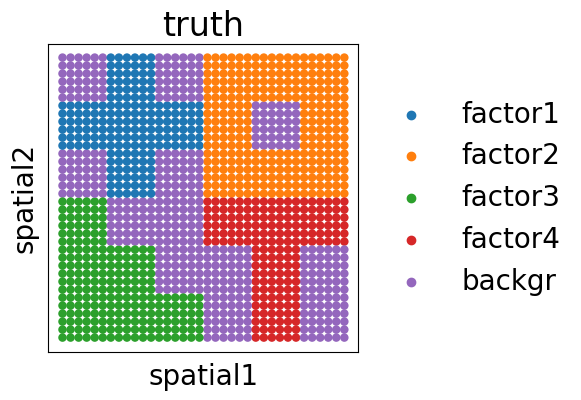

In [8]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots()
sc.pl.embedding(adata_omics1,basis='spatial',color='truth',size=150,ax=ax)

### Constructing the neighbor graph and training the PointNet++ Encoder

In [12]:
set_seed(7)
graph1 = prepare_data(adata_omics1, location="spatial", nb_neighbors=16).to(device)
graph2 = prepare_data(adata_omics2, location="spatial", nb_neighbors=16).to(device)
input_dim = graph1.express.shape[-1]
hidden_dim=32
model = extractModel(input_dim,hidden_dim,n_heads=4, n_layers=3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
start_time = time.time()
best_model = train_graph_extractor(graph1,graph2, model ,optimizer, device,epochs=600)

### Get multi-omics integrated representation `mixed_modal_features`

In [13]:
with torch.no_grad(): 
    MODEL=extractModel(input_dim=input_dim,hidden_dim=hidden_dim)
    MODEL.to(device)
    MODEL.load_state_dict(best_model)
    MODEL.eval()
    recon1, recon2,mixed_modal_features = MODEL(graph1, graph2)
    mixed_modal_features = mixed_modal_features.squeeze(0) 
    gene_expression_matrix = mixed_modal_features.cpu().detach().numpy()
adata_omics1.obsm['3d-OT']=gene_expression_matrix

### We use mclust for clustering

In [15]:
clustering(adata_omics1, n_clusters=5,key='3d-OT', method='mclust',random=2024,n_comp=20)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


### The Simulation 1 data clustering results

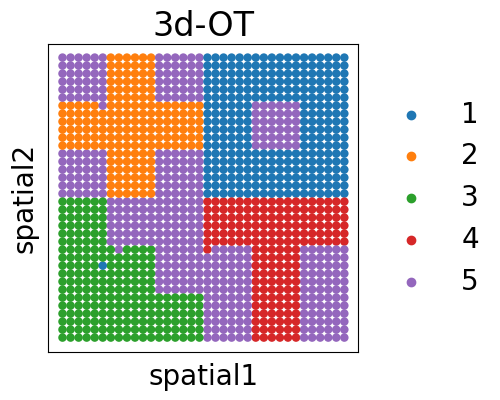

In [16]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots()
sc.pl.embedding(adata_omics1,basis='spatial',color='3d-OT',size=150,ax=ax)

###  Calculation of six evaluation indicators

In [17]:
import numpy as np
from sklearn.metrics import (homogeneity_score,mutual_info_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score
)

true_labels = np.array(adata_omics1.obs['truth'])
cluster_labels = np.array(adata_omics1.obs['3d-OT'])

homogeneity = homogeneity_score(true_labels, cluster_labels)
mutual_info = mutual_info_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("Homogeneity:", homogeneity)
print("Mutual Information:", mutual_info)
print("V-Measure:", v_measure)
print("AMI:", ami)
print("NMI:", nmi)
print("ARI:", ari)

Homogeneity: 0.9865381411532754
Mutual Information: 1.5265947069620323
V-Measure: 0.9867838115364901
AMI: 0.9867305499284305
NMI: 0.9867838115364901
ARI: 0.991938023457151


## Simulation Data 2

In [18]:
file_fold1 = '/home/dbj/mouse/spatialglue_alldata/Dataset14_Simulation2/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold1 + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold1 + 'adata_ADT.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
adata_omics1.obs['ground_truth'] = 1*np.array(adata_omics1.obsm['spfac'][:,0] + 2*adata_omics1.obsm['spfac'][:,1] + 3*adata_omics1.obsm['spfac'][:,2] + 4*adata_omics1.obsm['spfac'][:,3])
adata_omics1.obs['truth'] = adata_omics1.obs['ground_truth']
adata_omics1.obs['truth'].replace({1.0:'factor1',
                                   2.0:'factor2',
                                   3.0:'factor3',
                                   4.0:'factor4',
                                   0.0:'backgr'  #'backgr' means background.
                                              }, inplace=True)

list_ = ['factor1','factor2','factor3','factor4','backgr']
adata_omics1.obs['truth']  = pd.Categorical(adata_omics1.obs['truth'], 
                      categories=list_,
                      ordered=True)
adata_omics2.obs['truth']=adata_omics1.obs['truth']

In [20]:
n_protein = adata_omics2.n_vars
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=n_protein)

# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=n_protein)

In [21]:
set_seed(7)
graph1 = prepare_data(adata_omics1, location="spatial", nb_neighbors=16).to(device)
graph2 = prepare_data(adata_omics2, location="spatial", nb_neighbors=16).to(device)
input_dim = graph1.express.shape[-1]
hidden_dim=32
model = extractModel(input_dim,hidden_dim,n_heads=4, n_layers=3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
start_time = time.time()
best_model = train_graph_extractor(graph1,graph2, model ,optimizer, device,epochs=600)

In [22]:
with torch.no_grad(): 
    MODEL=extractModel(input_dim=input_dim,hidden_dim=hidden_dim)
    MODEL.to(device)
    MODEL.load_state_dict(best_model)
    MODEL.eval()
    recon1, recon2,mixed_modal_features = MODEL(graph1, graph2)
    mixed_modal_features = mixed_modal_features.squeeze(0) 
    gene_expression_matrix = mixed_modal_features.cpu().detach().numpy()
adata_omics1.obsm['3d-OT']=gene_expression_matrix

In [23]:
clustering(adata_omics1, n_clusters=5,key='3d-OT', method='mclust',random=2024,n_comp=20)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


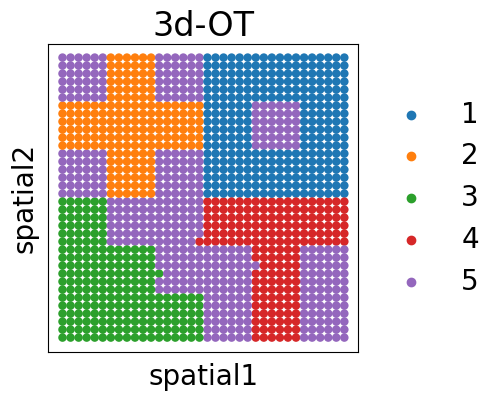

In [24]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots()
sc.pl.embedding(adata_omics1,basis='spatial',color='3d-OT',size=150,ax=ax)

In [25]:
import numpy as np
from sklearn.metrics import (homogeneity_score,mutual_info_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score
)

true_labels = np.array(adata_omics1.obs['truth'])
cluster_labels = np.array(adata_omics1.obs['3d-OT'])

homogeneity = homogeneity_score(true_labels, cluster_labels)
mutual_info = mutual_info_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("Homogeneity:", homogeneity)
print("Mutual Information:", mutual_info)
print("V-Measure:", v_measure)
print("AMI:", ami)
print("NMI:", nmi)
print("ARI:", ari)

Homogeneity: 0.9902103899455713
Mutual Information: 1.532277239988493
V-Measure: 0.9900401528982221
AMI: 0.9900000318982815
NMI: 0.9900401528982222
ARI: 0.9936498748034039


## Simulation Data 3

In [26]:
file_fold1 = '/home/dbj/mouse/spatialglue_alldata/Dataset15_Simulation3/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold1 + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold1 + 'adata_ADT.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
adata_omics1.obs['ground_truth'] = 1*np.array(adata_omics1.obsm['spfac'][:,0] + 2*adata_omics1.obsm['spfac'][:,1] + 3*adata_omics1.obsm['spfac'][:,2] + 4*adata_omics1.obsm['spfac'][:,3])
adata_omics1.obs['truth'] = adata_omics1.obs['ground_truth']
adata_omics1.obs['truth'].replace({1.0:'factor1',
                                   2.0:'factor2',
                                   3.0:'factor3',
                                   4.0:'factor4',
                                   0.0:'backgr'  #'backgr' means background.
                                              }, inplace=True)

list_ = ['factor1','factor2','factor3','factor4','backgr']
adata_omics1.obs['truth']  = pd.Categorical(adata_omics1.obs['truth'], 
                      categories=list_,
                      ordered=True)
adata_omics2.obs['truth']=adata_omics1.obs['truth']

In [27]:
n_protein = adata_omics2.n_vars
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=n_protein)

# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=n_protein)

In [28]:
set_seed(7)
graph1 = prepare_data(adata_omics1, location="spatial", nb_neighbors=16).to(device)
graph2 = prepare_data(adata_omics2, location="spatial", nb_neighbors=16).to(device)
input_dim = graph1.express.shape[-1]
hidden_dim=32
model = extractModel(input_dim,hidden_dim,n_heads=4, n_layers=3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
start_time = time.time()
best_model = train_graph_extractor(graph1,graph2, model ,optimizer, device,epochs=600)

In [29]:
with torch.no_grad(): 
    MODEL=extractModel(input_dim=input_dim,hidden_dim=hidden_dim)
    MODEL.to(device)
    MODEL.load_state_dict(best_model)
    MODEL.eval()
    recon1, recon2,mixed_modal_features = MODEL(graph1, graph2)
    mixed_modal_features = mixed_modal_features.squeeze(0) 
    gene_expression_matrix = mixed_modal_features.cpu().detach().numpy()
adata_omics1.obsm['3d-OT']=gene_expression_matrix

In [30]:
clustering(adata_omics1, n_clusters=5,key='3d-OT', method='mclust',random=2024,n_comp=20)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


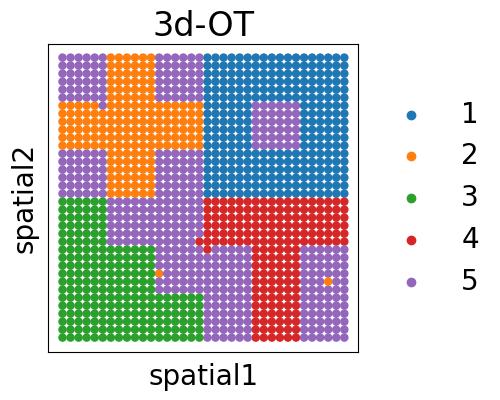

In [31]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots()
sc.pl.embedding(adata_omics1,basis='spatial',color='3d-OT',size=150,ax=ax)

In [32]:
import numpy as np
from sklearn.metrics import (homogeneity_score,mutual_info_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score
)

true_labels = np.array(adata_omics1.obs['truth'])
cluster_labels = np.array(adata_omics1.obs['3d-OT'])

homogeneity = homogeneity_score(true_labels, cluster_labels)
mutual_info = mutual_info_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("Homogeneity:", homogeneity)
print("Mutual Information:", mutual_info)
print("V-Measure:", v_measure)
print("AMI:", ami)
print("NMI:", nmi)
print("ARI:", ari)

Homogeneity: 0.9855043077852927
Mutual Information: 1.524994926394402
V-Measure: 0.984865368285187
AMI: 0.9848044320856825
NMI: 0.9848653682851871
ARI: 0.9896354033132985


## Simulation Data 4

In [33]:
file_fold1 = '/home/dbj/mouse/spatialglue_alldata/Dataset16_Simulation4/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold1 + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold1 + 'adata_ADT.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
adata_omics1.obs['ground_truth'] = 1*np.array(adata_omics1.obsm['spfac'][:,0] + 2*adata_omics1.obsm['spfac'][:,1] + 3*adata_omics1.obsm['spfac'][:,2] + 4*adata_omics1.obsm['spfac'][:,3])
adata_omics1.obs['truth'] = adata_omics1.obs['ground_truth']
adata_omics1.obs['truth'].replace({1.0:'factor1',
                                   2.0:'factor2',
                                   3.0:'factor3',
                                   4.0:'factor4',
                                   0.0:'backgr'  #'backgr' means background.
                                              }, inplace=True)

list_ = ['factor1','factor2','factor3','factor4','backgr']
adata_omics1.obs['truth']  = pd.Categorical(adata_omics1.obs['truth'], 
                      categories=list_,
                      ordered=True)
adata_omics2.obs['truth']=adata_omics1.obs['truth']

In [34]:
n_protein = adata_omics2.n_vars
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=n_protein)

# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=n_protein)

In [35]:
set_seed(7)
graph1 = prepare_data(adata_omics1, location="spatial", nb_neighbors=16).to(device)
graph2 = prepare_data(adata_omics2, location="spatial", nb_neighbors=16).to(device)
input_dim = graph1.express.shape[-1]
hidden_dim=32
model = extractModel(input_dim,hidden_dim,n_heads=4, n_layers=3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
start_time = time.time()
best_model = train_graph_extractor(graph1,graph2, model ,optimizer, device,epochs=600)

In [36]:
with torch.no_grad(): 
    MODEL=extractModel(input_dim=input_dim,hidden_dim=hidden_dim)
    MODEL.to(device)
    MODEL.load_state_dict(best_model)
    MODEL.eval()
    recon1, recon2,mixed_modal_features = MODEL(graph1, graph2)
    mixed_modal_features = mixed_modal_features.squeeze(0) 
    gene_expression_matrix = mixed_modal_features.cpu().detach().numpy()
adata_omics1.obsm['3d-OT']=gene_expression_matrix

In [37]:
clustering(adata_omics1, n_clusters=5,key='3d-OT', method='mclust',random=2024,n_comp=20)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


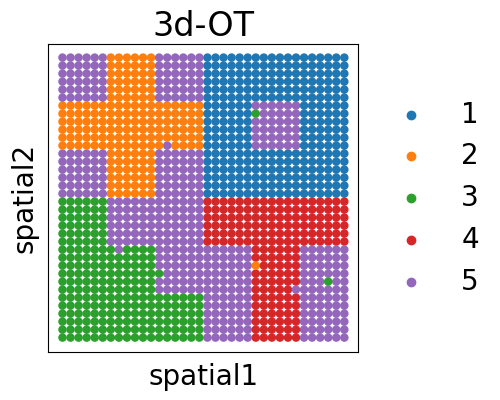

In [38]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots()
sc.pl.embedding(adata_omics1,basis='spatial',color='3d-OT',size=150,ax=ax)

In [39]:
import numpy as np
from sklearn.metrics import (homogeneity_score,mutual_info_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score
)

true_labels = np.array(adata_omics1.obs['truth'])
cluster_labels = np.array(adata_omics1.obs['3d-OT'])

homogeneity = homogeneity_score(true_labels, cluster_labels)
mutual_info = mutual_info_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("Homogeneity:", homogeneity)
print("Mutual Information:", mutual_info)
print("V-Measure:", v_measure)
print("AMI:", ami)
print("NMI:", nmi)
print("ARI:", ari)

Homogeneity: 0.9784479201344716
Mutual Information: 1.5140756891255591
V-Measure: 0.9785418546215845
AMI: 0.9784553911295736
NMI: 0.9785418546215846
ARI: 0.9858705495702517


## Simulation Data 5

In [40]:
file_fold1 = '/home/dbj/mouse/spatialglue_alldata/Dataset17_Simulation5/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold1 + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold1 + 'adata_ADT.h5ad')
adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
adata_omics1.obs['ground_truth'] = 1*np.array(adata_omics1.obsm['spfac'][:,0] + 2*adata_omics1.obsm['spfac'][:,1] + 3*adata_omics1.obsm['spfac'][:,2] + 4*adata_omics1.obsm['spfac'][:,3])
adata_omics1.obs['truth'] = adata_omics1.obs['ground_truth']
adata_omics1.obs['truth'].replace({1.0:'factor1',
                                   2.0:'factor2',
                                   3.0:'factor3',
                                   4.0:'factor4',
                                   0.0:'backgr'  #'backgr' means background.
                                              }, inplace=True)

list_ = ['factor1','factor2','factor3','factor4','backgr']
adata_omics1.obs['truth']  = pd.Categorical(adata_omics1.obs['truth'], 
                      categories=list_,
                      ordered=True)
adata_omics2.obs['truth']=adata_omics1.obs['truth']

In [41]:
n_protein = adata_omics2.n_vars
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=n_protein)

# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=n_protein)

In [42]:
set_seed(7)
graph1 = prepare_data(adata_omics1, location="spatial", nb_neighbors=16).to(device)
graph2 = prepare_data(adata_omics2, location="spatial", nb_neighbors=16).to(device)
input_dim = graph1.express.shape[-1]
hidden_dim=32
model = extractModel(input_dim,hidden_dim,n_heads=4, n_layers=3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
start_time = time.time()
best_model = train_graph_extractor(graph1,graph2, model ,optimizer, device,epochs=600)

In [43]:
with torch.no_grad(): 
    MODEL=extractModel(input_dim=input_dim,hidden_dim=hidden_dim)
    MODEL.to(device)
    MODEL.load_state_dict(best_model)
    MODEL.eval()
    recon1, recon2,mixed_modal_features = MODEL(graph1, graph2)
    mixed_modal_features = mixed_modal_features.squeeze(0) 
    gene_expression_matrix = mixed_modal_features.cpu().detach().numpy()
adata_omics1.obsm['3d-OT']=gene_expression_matrix

In [44]:
clustering(adata_omics1, n_clusters=5,key='3d-OT', method='mclust',random=2024,n_comp=20)

Using 3d-OT representation for clustering...
fitting ...
  |======================================================================| 100%


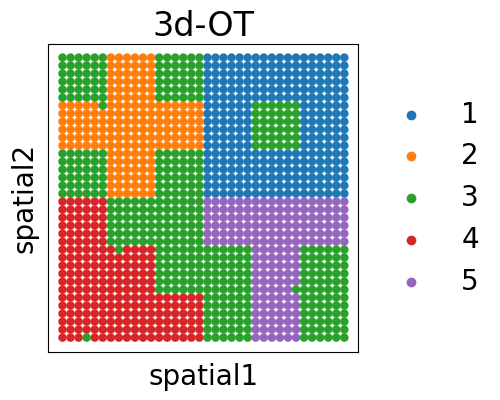

In [45]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 20

fig, ax = plt.subplots()
sc.pl.embedding(adata_omics1,basis='spatial',color='3d-OT',size=150,ax=ax)

In [46]:
import numpy as np
from sklearn.metrics import (homogeneity_score,mutual_info_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score
)

true_labels = np.array(adata_omics1.obs['truth'])
cluster_labels = np.array(adata_omics1.obs['3d-OT'])

homogeneity = homogeneity_score(true_labels, cluster_labels)
mutual_info = mutual_info_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)
ami = adjusted_mutual_info_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
ari = adjusted_rand_score(true_labels, cluster_labels)

print("Homogeneity:", homogeneity)
print("Mutual Information:", mutual_info)
print("V-Measure:", v_measure)
print("AMI:", ami)
print("NMI:", nmi)
print("ARI:", ari)

Homogeneity: 0.9865837185639651
Mutual Information: 1.5266652346294518
V-Measure: 0.9873642074944294
AMI: 0.9873132563119057
NMI: 0.9873642074944294
ARI: 0.9914416135115142
